# Alexa, how many people have your name?

***Work in Progress***

## Introduction

- Amazon Alexa, release dates [[1](#references)]
- Baby Names, England and Wales [[2](#references)]

**Other possible Sources:**

- https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data
- https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/vornamen-neugeborene.html
- https://www.dia.govt.nz/diawebsite.nsf/wpg_URL/Services-Births-Deaths-and-Marriages-Most-Popular-Male-and-Female-First-Names
- https://data.sa.gov.au/data/dataset/popular-baby-names

## Setup

### Imports

In [1]:
# Default
from pathlib import Path
from zipfile import ZipFile
import urllib
import datetime

# Extra

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pd.plotting.register_matplotlib_converters()
sns.set(style="darkgrid")

### Configuration

In [2]:
DATASETS = {
    "US": {
        "url": "https://www.ssa.gov/oact/babynames/names.zip",
        "filename": "names_us.zip",
        "release": datetime.date(2015, 6, 28),
    }
}

data_path = Path(".") / "data"

## Preparation

### Download Datasets

In [3]:
# Create target folder, if not existing
data_path.mkdir(parents=True, exist_ok=True)

# Download and store files
for name, desc in DATASETS.items():
    print(f"Downloading {name}-dataset from {desc['url']} ...")
    target_file = data_path / desc["filename"]
    if target_file.exists():
        print(f"Skipped download: {target_file} already exists.")
        continue
    urllib.request.urlretrieve(desc["url"], target_file)

print("Done.")

Skipped download: data/names_us.zip already exists.
Done.


### Prepare Dataset

Helper functions for simple loading datasets into pandas DataFrame:

In [4]:
def gen_dataset_us():
    """Generator yielding on year from US dataset.

    Yields:
        {pd.DataFrame} -- Dataframe containing names of one year

    """
    file_path = data_path / DATASETS["US"]["filename"]
    with ZipFile(file_path, "r") as zip:
        files = [f for f in zip.namelist() if f.endswith(".txt")]
        for f in files:
            df = pd.read_csv(zip.open(f), names=["Name", "Gender", "Count"])
            df["Year"] = pd.to_datetime(int(f[3:7]), format="%Y")
            df["Dataset"] = "US"
            df["Rank"] = df.groupby("Gender")["Count"].rank(method="max", ascending=False).astype(int)
            yield df


def load_datasets(names):
    """Helper function to load datasets into single dataframe.

    This also brings all datasets into the same form.

    Arguments:
        name {list} -- List of dataset short names, according to DATASETS

    Returns:
        {pd.DataFrame} -- All datasets in a single dataframe

    """
    list_dfs = []

    # Load individual Datasets
    if "US" in names or "all" in names:
        list_dfs.extend(gen_dataset_us())

    # Merge list of dataframes into single dataframe
    df_all = pd.concat(list_dfs, axis=0, ignore_index=True)

    return df_all

Actually loading the data:

In [5]:
df = load_datasets(["all"])
df.head()

,Name,Gender,Count,Year,Dataset,Rank
0,Mary,F,7065,1880-01-01,US,1
1,Anna,F,2604,1880-01-01,US,2
2,Emma,F,2003,1880-01-01,US,3
3,Elizabeth,F,1939,1880-01-01,US,4
4,Minnie,F,1746,1880-01-01,US,5


Calculate percentage per year, dataset and Gender:

In [6]:
def calculate_percentage(df):
    # Group by dataset and year
    df = df.groupby(["Dataset", "Year", "Gender", "Rank", "Name"]).agg({"Count": sum})

    # Calculate percentage of names per year
    df["Percentage"] = df.groupby(level=1).apply(lambda x: 100 * x / float(x.sum()))

    # Convert 'name' from multiindex to data column
    df = df.reset_index()
    return df

In [7]:
df = calculate_percentage(df)
df.head(10)

,Dataset,Year,Gender,Rank,Name,Count,Percentage
0,US,1880-01-01,F,1,Mary,7065,3.506482
1,US,1880-01-01,F,2,Anna,2604,1.292410
2,US,1880-01-01,F,3,Emma,2003,0.994124
3,US,1880-01-01,F,4,Elizabeth,1939,0.962359
4,US,1880-01-01,F,5,Minnie,1746,0.866570
5,US,1880-01-01,F,6,Margaret,1578,0.783189
6,US,1880-01-01,F,7,Ida,1472,0.730579
7,US,1880-01-01,F,8,Alice,1414,0.701793
8,US,1880-01-01,F,9,Bertha,1320,0.655139
9,US,1880-01-01,F,10,Sarah,1288,0.639257


### Quick Sanity Checks

In [8]:
perc_female_temp = sum(df[(df["Dataset"] == "US") & (df["Gender"] == "F") & (df["Year"] == "1920-01-01")]["Percentage"])
perc_male_temp = sum(df[(df["Dataset"] == "US") & (df["Gender"] == "M") & (df["Year"] == "1920-01-01")]["Percentage"])

print(f"US in 1920:\n{'-'*40}\nFemale names:\t{perc_female_temp:.2f} %")
print(f"Male names:\t{perc_male_temp:.2f} %")
print(f"Total:\t\t{perc_female_temp+perc_male_temp} %")

US in 1920:
----------------------------------------
Female names:	52.96 %
Male names:	47.04 %
Total:		100.00000000000017 %


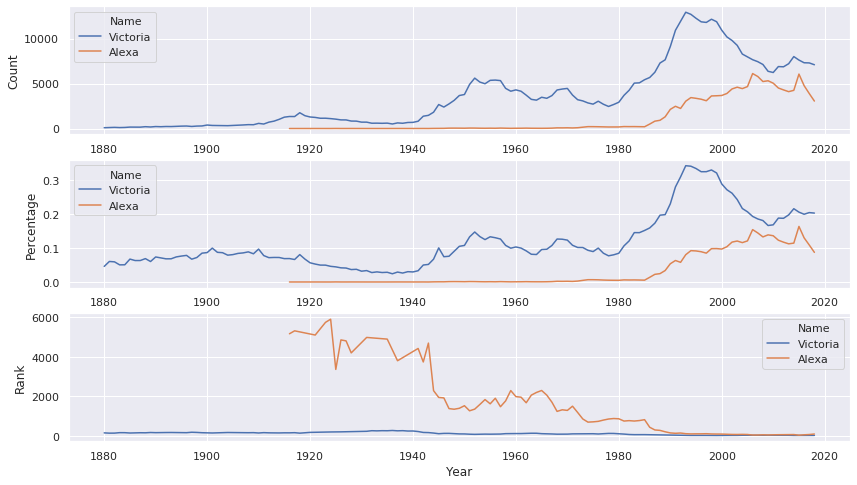

In [9]:
df_temp = df[(df["Name"].isin(["Alexa", "Victoria"])) & (df["Gender"] == "F")]

fig, ax = plt.subplots(3, 1, figsize=(14, 8))
sns.lineplot(x="Year", y="Count", hue="Name", data=df_temp, ax=ax[0])
sns.lineplot(x="Year", y="Percentage", hue="Name", data=df_temp, ax=ax[1])
sns.lineplot(x="Year", y="Rank", hue="Name", data=df_temp, ax=ax[2]);

**TODO: Wrap whole preprocessing**

## Visualization

### Filter datasets to "Alexa" only

In [14]:
df_alexa = df[(df["Name"] == "Alexa") & (df["Gender"] == "F")]
df_alexa = df_alexa.drop(columns="Name")
df_alexa.head()

,Dataset,Year,Gender,Rank,Count,Percentage
133506,US,1916-01-01,F,5162,5,0.000258
143378,US,1917-01-01,F,5311,5,0.000249
184682,US,1921-01-01,F,5098,6,0.000257
206801,US,1923-01-01,F,5739,5,0.000217
217549,US,1924-01-01,F,5899,5,0.000210


### Quick and dirty version

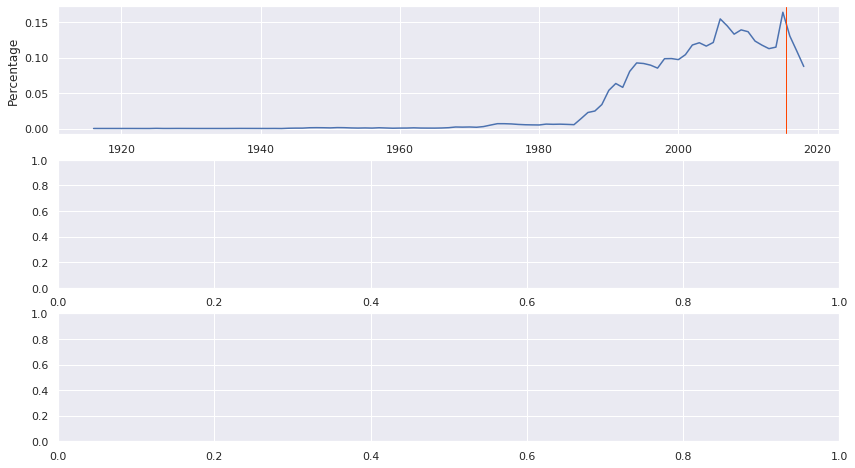

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(14, 8))
sns.lineplot(x="Year", y="Percentage", data=df_alexa, ax=ax[0])
ax[0].axvline(x=DATASETS["US"]["release"], color="orangered", linewidth=1);

### Final Version

<a name="references" />

## References

[1] Wikipedia contributors (2019): **Amazon Alexa**. In *Wikipedia - The Free Encyclopedia*. Retrieved Dec 28, 2019, from <https://en.wikipedia.org/w/index.php?title=Amazon_Alexa&oldid=932280905>

[2] Office for National Statistics (2018): **Baby names in England and Wales: 2018**. Retrieved Dec 28, 2019, from <https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/bulletins/babynamesenglandandwales/2018>